In [8]:
import json 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
# from ipykernel import kernelapp as app
import warnings 

from scipy import signal
from scipy import stats
from scipy.integrate import simps
from scipy.spatial import ConvexHull
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings('ignore')

In [12]:
''' reading file '''
file_path = r'C:\Users\jgaur\Downloads\Ashutosh 50\Deep Learning Projects 17 - Parkension Post Estimation using deep learning\parkinson data\UDysRS_UPDRS_Export\Communication_all_export.txt'
with open(file_path, 'r') as file:
    data = json.load(file)

In [13]:
print("Total Number of records are: {}".format(len(data)))

Total Number of records are: 387


In [14]:
''' keys in dictonary '''
print("Key in Dictionary:",data['26-1'].keys())
sorted(data['26-1']['position'].keys())

Key in Dictionary: dict_keys(['position', 'resp'])


['Lank',
 'Lelb',
 'Lhip',
 'Lkne',
 'Lsho',
 'Lwri',
 'Rank',
 'Relb',
 'Rhip',
 'Rkne',
 'Rsho',
 'Rwri',
 'face',
 'head',
 'neck']

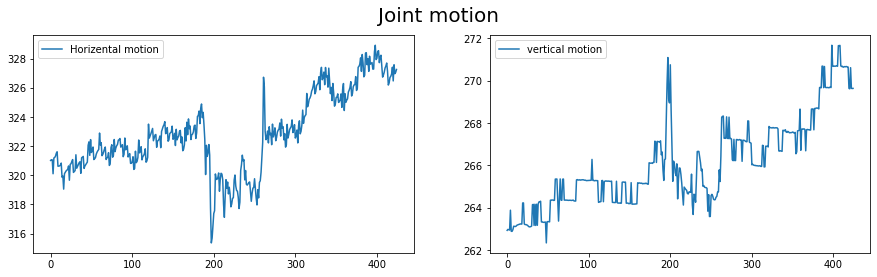

In [17]:
''' Data Visualization '''

val = "Rhip"
hor_disp_arr = np.array(data['26-1']['position'][val])[:,0]
ver_disp_arr = np.array(data['26-1']['position'][val])[:,1]

''' plotting '''
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(121)
ax.plot(hor_disp_arr,label='Horizental motion')
ax.legend(loc='best')

ax2 = fig.add_subplot(122)
ax2.plot(ver_disp_arr,label='vertical motion')
ax2.legend(loc='best')

plt.suptitle('Joint motion', fontsize=20);

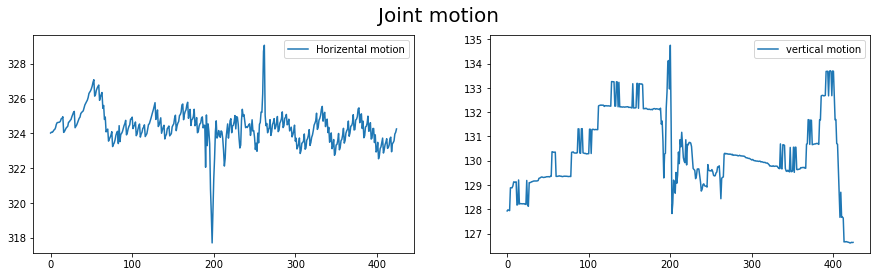

In [18]:
val = "neck"
hor_disp_arr = np.array(data['26-1']['position'][val])[:,0]
ver_disp_arr = np.array(data['26-1']['position'][val])[:,1]

''' plotting '''
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(121)
ax.plot(hor_disp_arr,label='Horizental motion')
ax.legend(loc='best')

ax2 = fig.add_subplot(122)
ax2.plot(ver_disp_arr,label='vertical motion')
ax2.legend(loc='best')

plt.suptitle('Joint motion', fontsize=20);

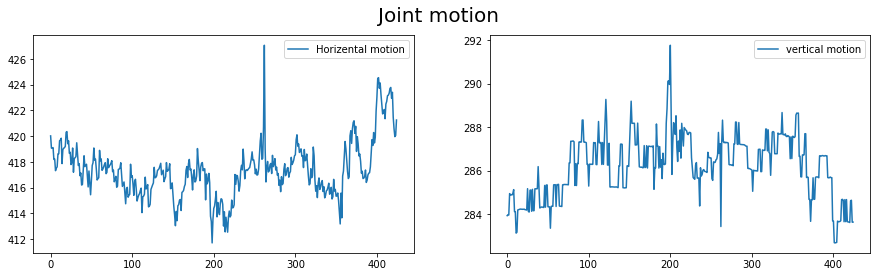

In [20]:
val = "Lkne"
hor_disp_arr = np.array(data['26-1']['position'][val])[:,0]
ver_disp_arr = np.array(data['26-1']['position'][val])[:,1]

''' plotting '''
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(121)
ax.plot(hor_disp_arr,label='Horizental motion')
ax.legend(loc='best')

ax2 = fig.add_subplot(122)
ax2.plot(ver_disp_arr,label='vertical motion')
ax2.legend(loc='best')

plt.suptitle('Joint motion', fontsize=20);

In [86]:
''' feature extraction '''

def com_hor_and_ver(hor_arr, ver_arr):
    com_arr = np.sqrt(np.square(hor_arr) + np.square(ver_arr))
    return com_arr

'''  Convert Displacement into velocity '''
def cvrt_into_vel(disp_arr, plot=False):
    vel_arr = np.diff(disp_arr)
    return vel_arr

''' Convert velocity into acceleration '''
def cvrt_into_acc(vel_arr, plot=False):
    acc_arr = np.diff(vel_arr)
    return acc_arr

'''Convert Acceleration into jerk'''
def cvrt_into_jerk(acc_arr, plot=False):
    jerk_arr = np.diff(acc_arr)
    return jerk_arr
    
    
def get_kin_feat(motion):
    max_m = np.amax(motion, axis=0)
    medain_m = np.median(motion)
    mean_m = np.mean(motion, axis=0)
    std_m = np.std(motion)
    iqr_range = stats.iqr(motion, interpolation = 'midpoint')
    return [max_m, medain_m, mean_m, std_m, iqr_range]

In [87]:
''' Spectral density feature '''

def get_spec_feat(sig, smp_freq=10, is_plt=False):
    sf = smp_freq
    win = 4 * sf
    
    '''calcutate the Spectral entropy.'''
    def spec_entropy(psd, normalize=False):
        psd_norm = np.divide(psd, psd.sum())
        se = -np.multiply(psd_norm, np.log2(psd_norm)).sum()
        if normalize:
            se /= np.log2(psd_norm.size)
        return se
    
    '''calculate the power band for given frequancy.'''
    def band_power(psd, freqs, min_freqs, max_freqs, is_plot=False):
        
        '''Define delta lower and upper limits'''
        low, high = min_freqs, max_freqs

        '''Find intersecting values in frequency vector'''
        idx_delta = np.logical_and(freqs >= low, freqs <= high)

        ''' plotting '''
        if is_plt:
            plt.figure(figsize=(7, 4))
            plt.plot(freqs, psd, lw=2, color='k')
            plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Power spectral density (uV^2 / Hz)')
            plt.xlim([0, 10])
            plt.ylim([0, psd.max() * 1.1])
            plt.title("Welch's periodogram")
            sns.despine()

        '''Frequency resolution'''
        freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25

        '''Compute the absolute power by approximating the area under the curve'''
        delt_p = simps(psd[idx_delta], dx=freq_res)
        
        return delt_p

    freqs, psd = signal.welch(sig, sf, nperseg=win)
    if is_plt:
        sns.set(font_scale=1.2, style='white')
        plt.figure(figsize=(8, 4))
        plt.plot(freqs, psd, color='k', lw=2)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power spectral density (V^2 / Hz)')
        plt.ylim([0, psd.max() * 1.1])
        plt.title("Welch's periodogram")
        plt.xlim([0, freqs.max()])
        sns.despine()
    #print(dir(psd))
    feat = {}
    feat["peak_magnitude"] = np.sqrt(psd.max())
    feat["entropy"] = spec_entropy(psd)
    feat["half_point"] = freqs.mean()
    
    feat["total_power"] = band_power(psd, freqs, freqs.min(), freqs.max(), is_plt)
    feat["power_bands_0.5_to_1"] = band_power(psd, freqs, 0.5, 1, is_plt)
    feat["power_bands_0_to_2"] = band_power(psd, freqs, 0, 2, is_plt)
    feat["power_bands_0_to_4"] = band_power(psd, freqs, 0, 4, is_plt)
    feat["power_bands_0_to_6"] = band_power(psd, freqs, 0, 6, is_plt)
    return feat

{'peak_magnitude': 0.9705993513670523,
 'entropy': 3.5156799267415058,
 'half_point': 2.5,
 'total_power': 0.9014011915838072,
 'power_bands_0.5_to_1': 0.21231359662876964,
 'power_bands_0_to_2': 0.7362227543049514,
 'power_bands_0_to_4': 0.8566117990549647,
 'power_bands_0_to_6': 0.9014011915838072}

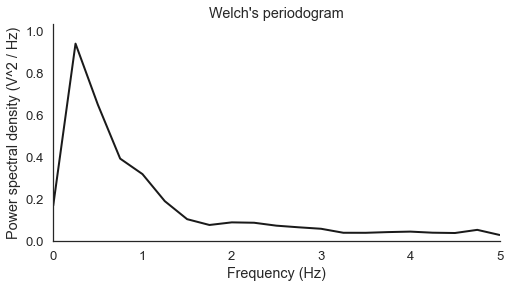

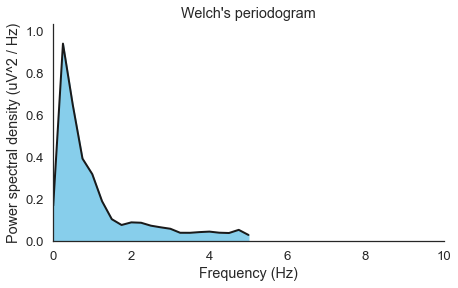

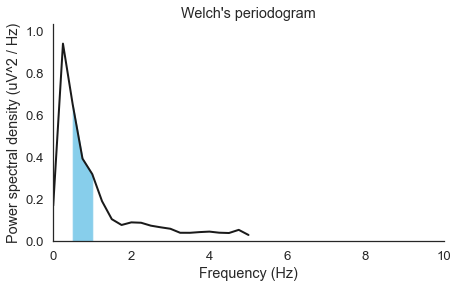

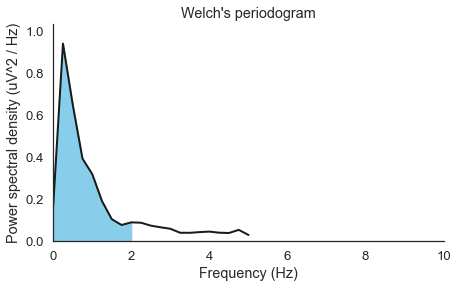

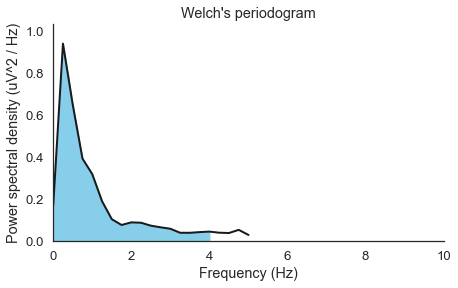

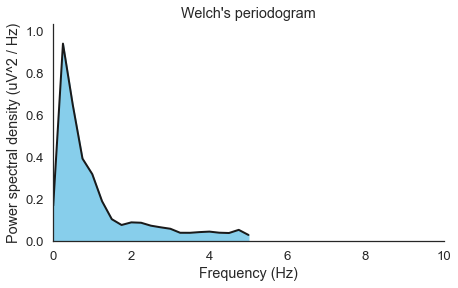

In [88]:
get_spec_feat(ver_disp_arr, is_plt=True)

In [89]:
''' Convex Hull Feature '''

def get_convex_hull_feature(d_arr):
    hull_feat = ConvexHull(d_arr)
    return hull_feat.area

In [90]:
get_convex_hull_feature(np.array(data['26-1']['position']["Lank"]))

95.84978188041217

In [101]:
''' record convertion '''

def record_con(pos_arr, pos_name, r_id="1-1"):
    pos_arr = np.array(pos_arr)
    hor_pos = pos_arr[:, 0]
    ver_pos = pos_arr[:, 1]
    
    disp_arr = com_hor_and_ver(hor_pos, ver_pos) 
    vel_arr = cvrt_into_vel(disp_arr)
    acc_arr = cvrt_into_acc(vel_arr)
    jerk_arr = cvrt_into_jerk(acc_arr)
    record = r_id.split("-")

    row = [r_id, int(record[0]), record[1], pos_name]
    row.extend(get_kin_feat(vel_arr))
    row.extend(get_kin_feat(acc_arr))
    row.extend(get_kin_feat(jerk_arr))
    
    spec_feat_disp = get_spec_feat(disp_arr)
    row.extend([value for key, value in spec_feat_disp.items()])
    spec_feat_vel = get_spec_feat(vel_arr)
    row.extend([value for key, value in spec_feat_vel.items()])
    convex_hull = get_convex_hull_feature(pos_arr)
    row.extend([convex_hull])
    return row

In [102]:
''' Iterate All other records '''

df = pd.DataFrame(columns=["combine_record_id","record_id", "term","position_name",
                          "speed_max", "speed_median", "speed_mean", "speed_std_div", "speed_iqr_range",
                         "acceleration_max", "acceleration_median", "acceleration_mean", "acceleration_std_div", "accelerati_iqr_range",
                         "jerk_max", "jerk_median", "jerk_mean", "jerk_std_div", "jerk_iqr_range",
                         "displacement_peak_magnitude","displacement_entropy", "displacement_half_point", "displacement_total_power",
                         "displacement_power_bands_0.5_to_1","displacement_power_bands_0_to_2", "displacement_power_bands_0_to_4", "displacement_power_bands_0_to_6",
                         "velocity_peak_magnitude","velocity_entropy", "velocity_half_point", "velocity_total_power",
                         "velocity_power_bands_0.5_to_1","velocity_power_bands_0_to_2", "velocity_power_bands_0_to_4", "velocity_power_bands_0_to_6",
                         "convexhull"])

In [103]:
idx = 0

for r_id, val in data.items():
    pos = val["position"]
    resp = val["resp"]
    for pos_name, pos_arr in pos.items():
        row = record_con(pos_arr, pos_name, r_id)
        df.loc[idx] = row
        idx += 1

In [104]:
''' displaying first 10 rows '''
df.head(10)

,combine_record_id,record_id,term,position_name,speed_max,speed_median,speed_mean,speed_std_div,speed_iqr_range,acceleration_max,...,displacement_power_bands_0_to_6,velocity_peak_magnitude,velocity_entropy,velocity_half_point,velocity_total_power,velocity_power_bands_0.5_to_1,velocity_power_bands_0_to_2,velocity_power_bands_0_to_4,velocity_power_bands_0_to_6,convexhull
0,26-1,26,1,head,2.792279,0.104618,-0.015622,0.630538,0.304877,5.131323,...,1.157774,0.364376,4.287856,2.5,0.422294,0.038663,0.137918,0.336459,0.422294,37.632285
1,26-1,26,1,neck,2.469307,0.098600,-0.000606,0.548473,0.334499,4.649736,...,0.620745,0.345455,4.243457,2.5,0.307684,0.018393,0.095626,0.238008,0.307684,29.794282
2,26-1,26,1,Lkne,3.136361,0.076740,0.002021,0.676698,0.806606,4.786833,...,0.684968,0.405524,4.188976,2.5,0.486046,0.019232,0.099006,0.373697,0.486046,36.917852
3,26-1,26,1,Lwri,5.198535,0.075536,0.016402,1.054253,1.094453,5.487450,...,1.901095,0.581605,4.242219,2.5,1.192271,0.091408,0.389776,0.946561,1.192271,37.675818
4,26-1,26,1,Rkne,3.659338,0.093118,0.029247,0.903657,1.181396,4.980085,...,1.487423,0.563078,4.205455,2.5,0.890508,0.037900,0.210545,0.671195,0.890508,145.438051
5,26-1,26,1,Lelb,2.388729,0.087028,0.006549,0.630261,0.611841,3.936843,...,0.910218,0.399440,4.266713,2.5,0.429022,0.027512,0.135335,0.330622,0.429022,32.153650
6,26-1,26,1,Lsho,3.377126,0.098620,0.001108,0.633851,0.472858,4.691207,...,0.903263,0.362294,4.248869,2.5,0.430376,0.028220,0.135963,0.341566,0.430376,29.343181
7,26-1,26,1,Rhip,3.092405,0.082036,0.021397,0.713963,0.864571,4.181641,...,1.074064,0.473776,4.171686,2.5,0.525334,0.026714,0.127043,0.389940,0.525334,37.914752
8,26-1,26,1,Rank,4.579702,0.077804,0.006936,0.901460,0.899729,4.681347,...,1.739043,0.540726,4.231232,2.5,0.838308,0.044310,0.229761,0.664828,0.838308,61.161962
9,26-1,26,1,face,4.013529,-0.165221,-0.010711,1.181875,1.053923,6.042260,...,1.864828,0.760965,4.087247,2.5,1.380594,0.042256,0.218646,0.954227,1.380594,52.678551


In [106]:
''' Rating '''

''' reading file '''
rating_path = r'C:\Users\jgaur\Downloads\Ashutosh 50\Deep Learning Projects 17 - Parkension Post Estimation using deep learning\parkinson data\UDysRS_UPDRS_Export\UDysRS.txt'

with open(rating_path, 'r') as r_file:
    rating = json.load(r_file)

In [107]:
rating.keys()

dict_keys(['Communication', 'Drinking', 'Higher'])

In [110]:
''' Creating Sub score of joints '''
sub_dict = {"Neck":["face"],
        "Larm":["Lsho", "Lelb", "Lwri"],
        "Rarm":["Rsho", "Relb", "Rwri"],
        "Trunk":["Rsho", "Lsho"],
        "Rleg":["Rhip", "Rkne", "Rank"],
        "Lleg":["Lhip", "Lkne", "Lank"]}

'''sub_score_dict'''
grps = df.groupby("combine_record_id")

pp_df = pd.DataFrame(columns=["combine_record_id","record_id", "term","position_name","sub_score",
                              "speed_max", "speed_median", "speed_mean", "speed_std_div", "speed_iqr_range",
                             "acceleration_max", "acceleration_median", "acceleration_mean", "acceleration_std_div", "accelerati_iqr_range",
                             "jerk_max", "jerk_median", "jerk_mean", "jerk_std_div", "jerk_iqr_range",
                             "displacement_peak_magnitude","displacement_entropy", "displacement_half_point", "displacement_total_power",
                             "displacement_power_bands_0.5_to_1","displacement_power_bands_0_to_2", "displacement_power_bands_0_to_4", "displacement_power_bands_0_to_6",
                             "velocity_peak_magnitude","velocity_entropy", "velocity_half_point", "velocity_total_power",
                             "velocity_power_bands_0.5_to_1","velocity_power_bands_0_to_2", "velocity_power_bands_0_to_4", "velocity_power_bands_0_to_6",
                             "convexhull", "UDysRS_rating"])

def find_r(r_id, sub_grp):
    order = {"Neck":0, "Rarm":1, "Larm":2, "Trunk":3, "Rleg":4, "Lleg":5}
    try:
        rating = rating['Communication'][str(r_id)][order[sub_grp]]
    except:
        rating = 0
    return rating
    
for r_id, group in grps:
    for idx, dict_ in group.iterrows():
        pos_name = dict_["position_name"]
        for sub_sc, val in sub_dict.items():
            if pos_name in val:
                dict_["sub_score"] = sub_sc
                dict_["UDysRS_rating"] = find_r(dict_["record_id"], sub_sc)
                pp_df = pp_df.append(dict_, ignore_index=True)

In [111]:
''' displaying first 10 rows'''
pp_df.head()

,combine_record_id,record_id,term,position_name,sub_score,speed_max,speed_median,speed_mean,speed_std_div,speed_iqr_range,...,velocity_peak_magnitude,velocity_entropy,velocity_half_point,velocity_total_power,velocity_power_bands_0.5_to_1,velocity_power_bands_0_to_2,velocity_power_bands_0_to_4,velocity_power_bands_0_to_6,convexhull,UDysRS_rating
0,1-1,1,1,Lkne,Lleg,7.621226,0.000055,-0.009828,1.698062,1.190246,...,0.963329,4.253132,2.5,2.739219,0.199188,0.984690,2.129187,2.739219,88.221826,0
1,1-1,1,1,Lwri,Larm,9.038624,0.000233,0.131159,1.042972,0.602927,...,0.828982,3.990733,2.5,0.826367,0.133442,0.527075,0.732966,0.826367,257.148438,0
2,1-1,1,1,Rkne,Rleg,3.524555,0.000038,0.007824,0.466179,0.007461,...,0.230852,4.182930,2.5,0.157589,0.006297,0.030704,0.112235,0.157589,21.371593,0
3,1-1,1,1,Lelb,Larm,3.696377,-0.000203,-0.065752,0.972254,0.676540,...,0.660396,4.244662,2.5,0.914604,0.122146,0.459827,0.700054,0.914604,116.737246,0
4,1-1,1,1,Lsho,Larm,2.462362,-0.000009,-0.009549,0.557721,0.008510,...,0.322026,4.285978,2.5,0.276645,0.018851,0.094961,0.194003,0.276645,39.668787,0


In [112]:
''' Mean of all sub score '''
grp_df = pp_df.groupby(['record_id', 'sub_score']).mean().reset_index()
grp_df.head(7)

,record_id,sub_score,speed_max,speed_median,speed_mean,speed_std_div,speed_iqr_range,acceleration_max,acceleration_median,acceleration_mean,...,displacement_power_bands_0_to_6,velocity_peak_magnitude,velocity_entropy,velocity_half_point,velocity_total_power,velocity_power_bands_0.5_to_1,velocity_power_bands_0_to_2,velocity_power_bands_0_to_4,velocity_power_bands_0_to_6,convexhull
0,1,Larm,2.378699,0.000008,0.006151,0.434431,0.145590,2.563187,-0.000183,-0.002905,...,4.020750,0.290431,4.180208,2.5,0.257181,0.032530,0.128346,0.204443,0.257181,51.447111
1,1,Lleg,2.801376,0.000005,-0.002543,0.607632,0.229252,4.019147,0.000188,-0.002594,...,1.194629,0.331893,4.239766,2.5,0.481217,0.034714,0.156380,0.365744,0.481217,26.924760
2,1,Neck,3.563685,-0.206350,0.016804,1.104360,0.673869,6.374849,0.025236,-0.001832,...,5.991191,0.744844,4.114691,2.5,1.166132,0.048349,0.234551,0.750230,1.166132,80.342687
3,1,Rarm,1.805619,0.000063,0.001008,0.349983,0.031725,2.890424,-0.000061,-0.001641,...,0.171142,0.200216,4.175002,2.5,0.101611,0.005229,0.024399,0.073403,0.101611,12.233846
4,1,Rleg,2.280942,0.000060,-0.001827,0.471195,0.038344,2.987845,0.000008,-0.001380,...,0.385678,0.266186,4.204739,2.5,0.212301,0.011795,0.052896,0.152180,0.212301,17.774876
5,1,Trunk,1.723720,0.000010,0.000035,0.316521,0.004802,2.431101,-0.000032,-0.002697,...,0.595505,0.181466,4.227550,2.5,0.096851,0.005998,0.028385,0.069674,0.096851,15.987596
6,2,Larm,3.313730,0.000220,-0.006432,1.024204,1.352590,2.674307,0.000632,-0.004236,...,20.106607,1.240900,3.201629,2.5,1.293431,0.236842,1.080049,1.207227,1.293431,46.703959


In [114]:
grp_df.columns

Index(['record_id', 'sub_score', 'speed_max', 'speed_median', 'speed_mean',
       'speed_std_div', 'speed_iqr_range', 'acceleration_max',
       'acceleration_median', 'acceleration_mean', 'acceleration_std_div',
       'accelerati_iqr_range', 'jerk_max', 'jerk_median', 'jerk_mean',
       'jerk_std_div', 'jerk_iqr_range', 'displacement_peak_magnitude',
       'displacement_entropy', 'displacement_half_point',
       'displacement_total_power', 'displacement_power_bands_0.5_to_1',
       'displacement_power_bands_0_to_2', 'displacement_power_bands_0_to_4',
       'displacement_power_bands_0_to_6', 'velocity_peak_magnitude',
       'velocity_entropy', 'velocity_half_point', 'velocity_total_power',
       'velocity_power_bands_0.5_to_1', 'velocity_power_bands_0_to_2',
       'velocity_power_bands_0_to_4', 'velocity_power_bands_0_to_6',
       'convexhull'],
      dtype='object')

In [119]:
''' Model '''

''' Regression '''
sub_sc_gr = grp_df.groupby(["sub_score"])

for sub_sc, ssg in sub_sc_gr:
    
    y = ssg["UDysRS_rating"].astype('float64') 
    X = ssg.drop(['record_id', 'sub_score', 'UDysRS_rating'], axis=1)
    
    ''' train test split '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    
    ''' Model '''
    li_reg = LinearRegression()
    
    ''' fit on data '''
    li_reg.fit(X_train, y_train)
    
    ''' calculating score '''
    print(li_reg.score(X_test, y_test))

In [118]:
''' Decision Tree'''

sub_score_gr = grp_df.groupby(["sub_score"])
for sub_score, sub_score_group in sub_score_gr:
    print(sub_score)
    y = sub_score_group["UDysRS_rating"].astype(str)
    X = sub_score_group.drop(['record_id', 'sub_score', 'UDysRS_rating'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    #print(X.head())
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    filename = '{}_decision_tree_model.sav'.format(sub_score)
    pickle.dump(reg, open(filename, 'wb'))
    print(clf.score(X_test, y_test))

' Decision Tree'